In [1]:
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
from omegaconf import OmegaConf
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
import torch

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
class Args:
    def __init__(self, dictionary):
        self.__dict__ = dictionary

    def __getattr__(self, key):
        if key in self.__dict__:
            return self.__dict__[key]
        else:
            raise AttributeError(f"'DictToObject' object has no attribute '{key}'")

    def __call__(self, key):
        return self.__getattr__(key)

def t2np(t):
    return ((t.permute(1, 2, 0) + 1) / 2).clamp(0,1).cpu().numpy()

Initialize args

In [3]:
config_dict = {
    "task_name": "cpg0000_batch",
    "img_size": 96,
    "latent_dim": 100,
    "hidden_dim": 512,
    "style_dim": 64,
    "stochastic": True,
    "z_dimension": 10,
    "dim_in": 64,
    "pert_modelling": False,
    "batch_key": "PLATE",
    "subsample_frac": 0.05,
    "lambda_reg": 1,
    "lambda_cyc": 1,
    "lambda_sty": 1,
    "lambda_ds": 1,
    "total_epochs": 20,
    "ds_iter": 100000,
    "resume_iter": 0,
    "batch_size": 32,
    "val_batch_size": 20,
    "lr": 0.0001,
    "f_lr": 0.0001,
    "beta1": 0,
    "beta2": 0.99,
    "weight_decay": 0.0001,
    "num_outs_per_domain": 10,
    "single_style": True,
    "ood_set": None,
    "mol_list": None,
    "balanced": False,
    "trainable_emb": True,
    "dataset_name": "cpg0000",
    "n_channels": 5,
    "num_workers": 6,
    "seed": 42,
    "image_path": "/lustre/groups/ml01/datasets/projects/cpg0000_alessandro/cpg0000_u2os_normalized_segmented_large",
    "data_index_path": "/lustre/groups/ml01/datasets/projects/cpg0000_alessandro/metadata/metadata_large.csv",
    "embedding_path": None,
    "experiment_directory": "../project_folder/experiments/",
    "sample_dir": "sample",
    "checkpoint_dir": "checkpoint",
    "basal_vs_real_folder": "basal_vs_real",
    "naming_key": "dataset_name",
    "embedding_folder": "embeddings",
    "resume_dir": "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240101_348bb3f1-6a5b-47f2-9388-b05ba74dfcc6_cpg0000_batch/",
    "augment_train": True,
    "normalize": True,
    "print_every": 10,
    "sample_every": 1000,
    "save_every": 500,
    "eval_every": 500,
    "encode_rdkit": True,
    "num_layers_mapping_net": 1,
    "filename": "epoch_{epoch:04d}",
    "monitor": "fid_transformations",
    "mode": "min",
    "save_last": True,
    "offline": False,
    "project": "cpg0000_batch",
    "log_model": False,
    "accelerator": "gpu",
    "log_every_n_steps": 10
}

args = OmegaConf.create(config_dict)

In [4]:
dest_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240101_348bb3f1-6a5b-47f2-9388-b05ba74dfcc6_cpg0000_batch"

Initialize data module

In [5]:
dataloader = CellDataLoader(args)

Initialize solver 

In [6]:
solver = IMPAmodule(args, dest_dir, dataloader)
solver._load_checkpoint(20)

Number of parameters in generator: 24319877
Number of parameters in style_encoder: 14330624
Number of parameters in discriminator: 14302922
Number of parameters in mapping_network: 7104
Initializing embedding_matrix...
Initializing generator...
Initializing style_encoder...
Initializing discriminator...
Initializing mapping_network...
Loading checkpoint from /home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240101_348bb3f1-6a5b-47f2-9388-b05ba74dfcc6_cpg0000_batch/checkpoint/000020_nets.ckpt...
/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240101_348bb3f1-6a5b-47f2-9388-b05ba74dfcc6_cpg0000_batch/checkpoint/000020_nets.ckpt
Loading checkpoint from /home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240101_348bb3f1-6a5b-47f2-9388-b05ba74dfcc6_cpg0000_batch/checkpoint/000020_embeddings.ckpt...
/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240101_348bb3f1-6a5b-47f2-9388-b0

In [7]:
train_dataloader = dataloader.train_dataloader()
val_dataloader = dataloader.val_dataloader()

In [8]:
target_folder = Path("/lustre/groups/ml01/datasets/projects/cpg0000_alessandro/cpg0000_u2os_normalized_segmented_large_transported")

In [9]:
# Transform all with the same random vector. Take the mean 
z_common = torch.randn(1, 100, args.z_dimension).mean(1).cuda()
with torch.no_grad():
    for loader in [train_dataloader, val_dataloader]:
        for batch in tqdm(loader):
            # # Get image 
            X = batch["X"].cuda()
            z = z_common.repeat(X.shape[0], 1)
            # Transport everything to a chosen batch, here we pick 0
            y = 0*torch.ones(X.shape[0]).long().cuda()
            y = solver.embedding_matrix(y).cuda()
            y = torch.cat([y, z], dim=1)
            y = solver.nets.mapping_network(y)
            # Transport image to new batch
            _, X_generated = solver.nets.generator(X, y)
            for i, filename in enumerate(batch["file_names"]):
                plate, well, view, no = filename.split("_")
                to_save = t2np(X_generated[i])
                to_save = (to_save*255).astype(np.uint8)
                path = target_folder/plate/f"{well}_{view}"
                
                assert os.path.exists(Path(args.image_path)/plate/f"{well}_{view}"/f"{well}_{view}_{no}.npy")

                # Save images 
                os.makedirs(path,  exist_ok=True)
                np.save(path/f"{well}_{view}_{no}.npy", to_save)

100%|██████████| 4352/4352 [14:07<00:00,  5.14it/s]


Real


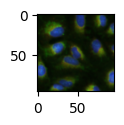

Transformed


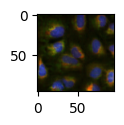

Real


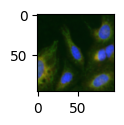

Transformed


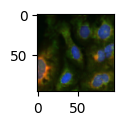

Real


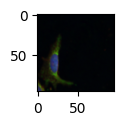

Transformed


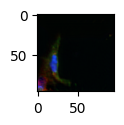

Real


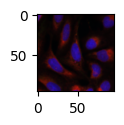

Transformed


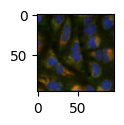

Real


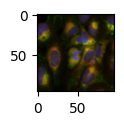

Transformed


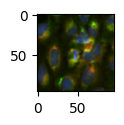

Real


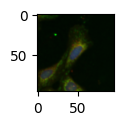

Transformed


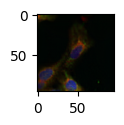

Real


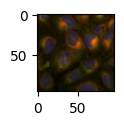

Transformed


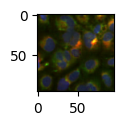

Real


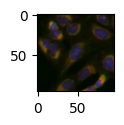

Transformed


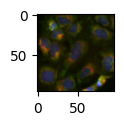

Real


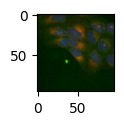

Transformed


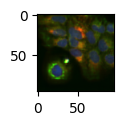

Real


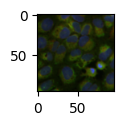

Transformed


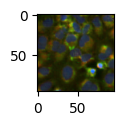

Real


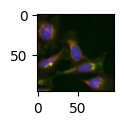

Transformed


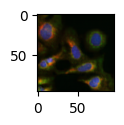

Real


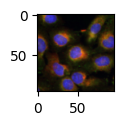

Transformed


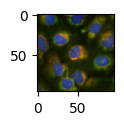

Real


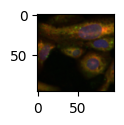

Transformed


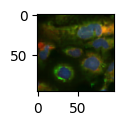

Real


IndexError: index 13 is out of bounds for dimension 0 with size 13

<Figure size 100x100 with 0 Axes>

In [11]:
for i in range(args.batch_size):
    print("Real")
    plt.figure(figsize=(1,1))
    plt.imshow(t2np(X[i])[:,:,[1,3,4]])
    plt.show()
    print("Transformed")
    plt.figure(figsize=(1,1))
    plt.imshow(t2np(X_generated[i])[:,:,[1,3,4]])
    plt.show()

In [ ]:
z = torch.randn(1, 1000, args.z_dimension).mean(1).cuda()


In [ ]:
z.repeat(16,1).shape

In [ ]:
import os
from pathlib import Path
import numpy as np
path_cpg0000 = Path("/lustre/groups/ml01/datasets/projects/cpg0000_alessandro/cpg0000_u2os_normalized_segmented_large")

for plate in os.listdir(path_cpg0000):
    for well in os.listdir(path_cpg0000 /plate):
        for img in os.listdir(path_cpg0000 /plate / well):
            im = np.load(path_cpg0000 /plate / well/img)
            assert im.dtype == np.uint8